## Predicting 21cm Ionization History curves using Emupy v1.0.0

**Lawrence Phillips**
<br>
**July, 2021**

---

Here we will create interpolation functions (an emulator) for the spherically-averaged 21cm brightness temperature power spectrum $P_{21}(k,z)$. The data itself are actually in the units $\Delta^{2}_{21}(k,z) = P_{21}(k,z)k^{3}/(2\pi^{2})\ [\rm{mK}^{2}]$. The data in `lh_training.pkl` are drawn from a random Latin-Hypercube design in a **three dimensional** model parameter space of the UV ionizing efficiency parameter ($\zeta$), the virial temperature of star-forming halos ($T_{vir}^{min}$), and the mean-free path of ionizing photons through ionized regions ($R_{mfp}$). See [Kern et al. 2017](https://arxiv.org/abs/1705.04688) for parameterization details. The data in `cross_inspection.pkl` are drawn from a uniform grid across each individual parameter while holding all others constant. 

The example below has certain code dependencies. See [emupy](github.com/nkern/emupy) for dependency details and installation instructions.

In [3]:
# Import modules
%matplotlib inline
import numpy as np
import emupy
import pickle as pkl
import sklearn.gaussian_process as gp
import astropy.stats as astats
import matplotlib.pyplot as plt
import torch
import h5py
import os

In [167]:
d_names = os.listdir('/users/lphillip/mylustre/gitrepos/emupy/examples/cm_batchs')
d_struct = {} #Here we will store the database structure
for i in d_names:
    f = h5py.File('/users/lphillip/mylustre/gitrepos/emupy/examples/cm_batchs/'+i,'r+')
    print(f.keys())
    d_struct[i] = f.keys()
    f.close()

# A) empty all the groups in the new .h5 file 
for i in d_names:
    for j  in d_struct[i]:
        !h5copy -i '{i}' -o 'output.h5' -s {j} -d {j}

<KeysViewHDF5 ['E_0', 'T_vir', 'x_21cmfast', 'z', 'zeta']>
<KeysViewHDF5 ['E_0', 'T_vir', 'x_21cmfast', 'z', 'zeta']>
<KeysViewHDF5 ['E_0', 'T_vir', 'x_21cmfast', 'z', 'zeta']>
<KeysViewHDF5 ['E_0', 'T_vir', 'x_21cmfast', 'z', 'zeta']>
<KeysViewHDF5 ['E_0', 'T_vir', 'x_21cmfast', 'z', 'zeta']>
<KeysViewHDF5 ['E_0', 'T_vir', 'x_21cmfast', 'z', 'zeta']>
<KeysViewHDF5 ['E_0', 'T_vir', 'x_21cmfast', 'z', 'zeta']>
<KeysViewHDF5 ['E_0', 'T_vir', 'x_21cmfast', 'z', 'zeta']>
<KeysViewHDF5 ['E_0', 'T_vir', 'x_21cmfast', 'z', 'zeta']>
<KeysViewHDF5 ['E_0', 'T_vir', 'x_21cmfast', 'z', 'zeta']>


TypeError: Not a location id (invalid object ID)

In [123]:
#read hdf5 file
f_cm = h5py.File("qsub100sims21cmfastsimscopy.hdf5", "r+")
f_zr = h5py.File("qsub1000simszresims-Copy1.hdf5", "r+")
f_zr.keys()

<KeysViewHDF5 ['alpha', 'k_0', 'x_zreion', 'z', 'z_mean']>

In [124]:
#extract zreion and 21cmFast file data into np arrays
zr_params_array = np.array([f_zr['alpha'],f_zr['k_0'],f_zr['z_mean']]).T
x_zreion = np.array(f_zr['x_zreion'])

cm_params_array = np.array([f_cm['E_0'],f_cm['zeta'],f_cm['T_vir']]).T
z_array = np.array(f_cm['z'])
x_21cmfast = np.array(f_cm['x_21cmfast'])

#z scales are the same size in both 
print(x_zreion.shape)

(100, 30)


In [148]:
#reassigning to match nkerns original code

#Using 90% of the simulated data for training
#Slice the last 90%
data_tr_cm = x_21cmfast[10:100]
grid_tr_cm = cm_params_array[10:100]

data_tr_zr = x_zreion[10:100]
grid_tr_zr = zr_params_array[10:100]

#Using 10% of the simulated data for training
#Slice the first 10%
data_cr_cm = x_21cmfast[1:10]
grid_cr_cm = cm_params_array[1:10]

data_cr_zr = x_zreion[1:10]
grid_cr_zr = zr_params_array[1:10]

`data_tr` is the array containing our training data y-values. It has shape `(200, 33)`, which corresponds to 200 individual samples within our 3-dimensional model space, each with 33 individual data elements of $\Delta^{2}_{21}$ that we want to emulate. The 33 elements of the data correspond to the power spectrum across 11 $k$ values found in `k_range` at redshifts $z = [8, 9, 10]$.

`grid_tr` is the array containing the training data x-values. It has shape `(200, 3)`, which corresponds to the 200 individual samples within our 3-dimensional model space, each with a unique vector position in the 3-d parameter space.

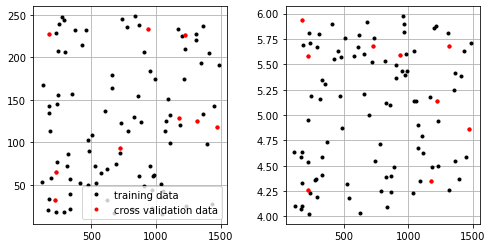

In [126]:
# Plot training data x-values
fig = plt.figure(figsize=(8,4))
fig.subplots_adjust(wspace=0.3)

ax = fig.add_subplot(121)
ax.grid(True)
p0, = ax.plot(grid_tr.T[0], grid_tr.T[1], 'k.')
p1, = ax.plot(grid_cr.T[0], grid_cr.T[1], 'r.')
ax.plot(grid_cr.T[0], grid_cr.T[1], 'r.')
# ax.set_xlabel('$\zeta$', fontsize=16)
# ax.set_ylabel('$T_{vir}^{min}\ [{K}]$', fontsize=16)
ax.legend([p0,p1],['training data', 'cross validation data'])

ax = fig.add_subplot(122)
ax.grid(True)
ax.plot(grid_tr.T[0], grid_tr.T[2], 'k.')
ax.plot(grid_cr.T[0], grid_cr.T[2], 'r.')
ax.plot(grid_cr.T[0], grid_cr.T[2], 'r.')
# ax.set_xlabel('$\zeta$', fontsize=16)
# ax.set_ylabel('$R_{mfp}\ [{pltc}]$', fontsize=16)

__Figure 1__ | Training data feature values across the three dimensional astrophysical parameter space. Black points are the training data, red points are the cross-validation data drawn specifically to show the behavior of the prediction wrt each parameter indepedently.

In [142]:
# initialize emulator
E_cm = emupy.NNEmulator()
E_zr = emupy.NNEmulator()

# scale training target data
E_cm.scale_data(data_tr_cm, lognorm=True, center=False, whiten=False, save=True);
E_zr.scale_data(data_tr_zr, lognorm=True, center=False, whiten=False, save=True);

# sphere training feature data
E_cm.sphere(grid_tr_cm, save=True);
E_zr.sphere(grid_tr_zr, save=True);

#do not have a continous distrubition of samples, what does the dervivative look like around a given point 

/lustre/aoc/projects/hera/lphillip/anaconda3/envs/21cmfast/lib/python3.9/site-packages/emupy-1.0.0-py3.9.egg/emupy/emulator.py:213: RuntimeWarning: divide by zero encountered in log
  y_scaled = np.log(y)


In [143]:
# setup NN if NN emulating
np.random.seed(0)
torch.set_default_dtype(torch.float64)
layers = [torch.nn.Linear(3, 50), torch.nn.Linear(50, 100), torch.nn.Linear(100, 30)]
inits = [torch.nn.init.xavier_normal, torch.nn.init.xavier_normal, torch.nn.init.xavier_normal]
activations = [torch.nn.Tanh(), torch.nn.Tanh(), None]

# E_cm.set_layers(layers)
# E_cm.set_inits(inits)
# E_cm.set_activations(activations)

E_zr.set_layers(layers)
E_zr.set_inits(inits)
E_zr.set_activations(activations)

/lustre/aoc/projects/hera/lphillip/anaconda3/envs/21cmfast/lib/python3.9/site-packages/emupy-1.0.0-py3.9.egg/emupy/nn.py:75: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init(self.layers[i].weight)


In [144]:
# train
#E_cm.train(E.Xsph, E.y_scaled, Nepochs=1000)
E_zr.train(E.Xsph, E.y_scaled, Nepochs=1000)

In [97]:
#plt.plot(E.loss)
# plt.yscale('log')
# plt.grid()
# plt.xlabel("Epoch")
# plt.ylabel("loss")

In [145]:
#x0_predict = E_cm.predict(E.sphere(grid_cr_cm[0], Xmean=E.Xmean, L=E.L), unscale=True)
x1_predict = E_zr.predict(E.sphere(grid_cr_zr[0], Xmean=E.Xmean, L=E.L), unscale=True)

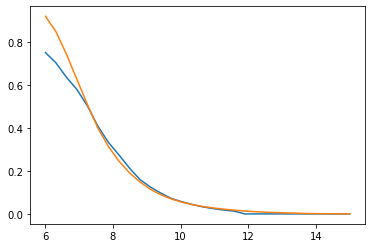

In [131]:
plt.plot(z_array,x0_predict.squeeze())
plt.plot(z_array, data_cr_cm[0,:])

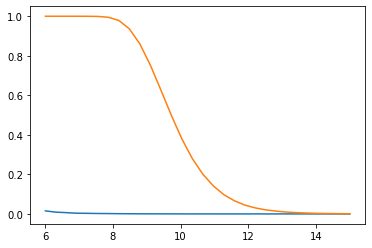

In [147]:
plt.plot(z_array,x1_predict.squeeze())
plt.plot(z_array, data_cr_zr[0,:])